# Unsupervised SRBM

We can train RBM unsupervised.

Originally, we use data and model distribution to maximize the loglikelihood.

\begin{align}
{\rm Max} \left\langle \ln ( q(\phi) ) \right\rangle_{p}
\end{align}

Instead we can use generated data to estimate p.

\begin{align}
\mathcal{L} &= {\rm Max} \left\langle \ln ( p(\phi) ) \right\rangle_{q} \\
&= {\rm Max} \left\langle -S_{\phi}(\phi) - \ln Z \right\rangle
\end{align}

\begin{align}
\frac{\partial \mathcal{L}}{\partial w_{ia}} &= -\frac{\partial \langle S_{\phi}(\phi^{\rm rbm}) \rangle_{q}}{\partial w_{ia}}
 - \langle \phi_i \phi_j w_{ja} \rangle_{q} \\
 &= \left\langle S_{\phi}(\phi) \frac{\partial S_{\rm RBM}}{\partial w_{ia}} \right\rangle - \langle \phi_i \phi_j w_{ja} \rangle \\
 &= \left\langle S_{\phi} (\phi) \phi_i \phi_j w_{ja} \right\rangle - \langle \phi_i \phi_j w_{ja} \rangle
\end{align}

or

\begin{align}
\frac{\partial \mathcal{L}}{\partial w_{ia}} &= \langle \phi_i \phi_j w_{ja} \rangle_{q}
 - \langle \phi_i \phi_j w_{ja} \rangle_{q} \\
 &= K^{-1}_{\phi, ij}w_{ja} - K^{-1}_{\rm RBM, ij} w_{ja}
\end{align}

We have to know the expression for one-point and two point function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import random

# Change accordingly to your directory structure
sys.path.append('../')
import RBM

In [2]:
N = 10

In [3]:
conf_id = 'phi_1d_10N_2m'
# data_file = np.load('../datas/scalar_field/phi_1d_10N_2m_2/phi_1d_10N_2m_2.npy')
# data_file = np.load('../datas/scalar_field/'+conf_id+'/'+conf_id+'.npy')
# n_data = len(data_file)

In [4]:
def S(field, m):
    N = len(field)
    s = 0.
    for i in range(N):
        s += -0.5*field[i]*(field[(i+1)%N]
                            + field[(i-1)%N] - (2.+ m[i]**2)*field[i])

    return s/N

def S_fast(field,m=2.):
    s = m**2 * field**2
    s += 2.*field**2
    s -= field*torch.roll(field,-1,dims=1)
    s -= field*torch.roll(field,1, dims=1)
    return torch.sum(0.5*s)/N

In [5]:
# True matrix
m = 2
W = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if i==j:
            W[i][j] = 2 + m**2
#             W[i][j] = 2.
        elif (i % N == (j+1) %N) or (i % N == (j-1) %N):
            W[i][j] = -1
print(W)
K_phi = W

[[ 6. -1.  0.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  6. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  6. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  6. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  6. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  6. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  6. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  6. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  6. -1.]
 [-1.  0.  0.  0.  0.  0.  0.  0. -1.  6.]]


$w w^T = -K_{\phi} + m^2$

In [10]:
# Cholesky solution
W_phi = np.linalg.cholesky(-K_phi + np.diag([5**2]*N))

In [11]:
-K_phi + np.diag([5**2]*N)

array([[19.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1., 19.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., 19.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., 19.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., 19.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., 19.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., 19.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., 19.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 19.]])

In [12]:
W_phi @ W_phi.T

array([[ 1.90000000e+01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.00000000e+00,  1.90000000e+01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.37242037e-19],
       [ 0.00000000e+00,  1.00000000e+00,  1.90000000e+01,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -4.30756862e-20],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.90000000e+01,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.15303820e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.90000000e+01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.

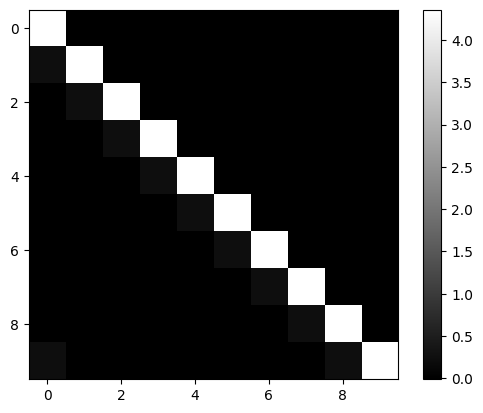

In [13]:
plt.imshow(W_phi, cmap='gray')
plt.colorbar()
plt.show()

In [14]:
W_phi

array([[ 4.35889894e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.29415734e-01,  4.35285750e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.29734146e-01,  4.35284071e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.29735032e-01,
         4.35284066e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.29735035e-01,  4.35284066e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

In [15]:
N = 10
# Initialization scheme.
# Initialize w with Cholesky solution W_phi and mass=5 sigma=1
# init_cond = {'w':torch.DoubleTensor(W_phi.copy()),'m':5., 'sig':1.}
# init_cond = {'m':3., 'sig':1., 'm_scheme':'local'}
init_cond = {'m':3., 'sig':1., 'm_scheme':'global'}

# Reproducibility
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

# Initialize SRBM
rbm = RBM.SRBM(n_v=N,n_h=N,k=10,init_cond=init_cond)

# For autograd if implimented
# train_op = optim.SGD(rbm.parameters(),1e-7)
# train_op = optim.Adam(rbm.parameters(),1e-5)

# Check initial coupling matrix
print(rbm.w)

# Training parameters
lr = 1e-1
epochs = 3000
batch_size = 64

# Initial field.
# Cold start
init_field = torch.ones((batch_size,N))

# wrap K_phi to torch
K_phi_tc = torch.DoubleTensor(K_phi)

Initializing model SRBM-230411_170615
Parameter containing:
tensor([[-0.0088,  0.0342,  0.0411,  0.1005, -0.0112, -0.0599, -0.0098, -0.0351,
          0.0721, -0.0217],
        [-0.1043,  0.0245, -0.0989, -0.0520,  0.0659,  0.0641,  0.0784,  0.0657,
         -0.1635, -0.0611],
        [ 0.0600, -0.0877,  0.0965, -0.0193,  0.0374,  0.0093,  0.0302,  0.1312,
         -0.0561,  0.0190],
        [-0.0166,  0.0911, -0.1786, -0.0935,  0.0884,  0.1582,  0.0110,  0.0101,
         -0.0166,  0.0321],
        [ 0.0120,  0.0515, -0.0091,  0.2364, -0.0410,  0.0516, -0.1173, -0.0743,
          0.0592,  0.0082],
        [-0.0414,  0.1154,  0.0116,  0.0937,  0.0796, -0.0011, -0.0024, -0.0389,
         -0.0420, -0.0436],
        [ 0.0315, -0.1719,  0.0915, -0.0237,  0.2403, -0.0714, -0.2536,  0.0387,
         -0.1892, -0.1034],
        [-0.0255, -0.0399, -0.1668,  0.0549,  0.1011,  0.0406, -0.0134,  0.0534,
         -0.1141, -0.1743],
        [ 0.1155, -0.0821, -0.1105,  0.0952, -0.0263, -0.0038,  0.27

In [16]:
# Save and load model
rbm.save('./')
saved_model = rbm.name
print(saved_model)
rbm = RBM.SRBM(load='./'+saved_model+'.npz')

SRBM-230411_170615
Loading model from ./SRBM-230411_170615.npz


In [ ]:
!rm *.npz

In [17]:
# Train the model
history = rbm.unsup_fit(K_phi_tc, S_fast, epochs, lr, batch_size, verbose=True, lr_decay=0.99)

epoch :0 lr: 0.09900 loss : -0.17300
epoch :64 lr: 0.09801 loss : 0.03574
epoch :128 lr: 0.09703 loss : 0.02008
epoch :192 lr: 0.09606 loss : 0.04161
epoch :256 lr: 0.09510 loss : 0.03102
epoch :320 lr: 0.09415 loss : 0.01855
epoch :384 lr: 0.09321 loss : -0.00544
epoch :448 lr: 0.09227 loss : -0.00370
epoch :512 lr: 0.09135 loss : 0.02059
epoch :576 lr: 0.09044 loss : -0.00245
epoch :640 lr: 0.08953 loss : 0.00226
epoch :704 lr: 0.08864 loss : -0.00471
epoch :768 lr: 0.08775 loss : 0.01214
epoch :832 lr: 0.08687 loss : 0.01792
epoch :896 lr: 0.08601 loss : 0.00718
epoch :960 lr: 0.08515 loss : 0.00423
epoch :1024 lr: 0.08429 loss : -0.01556
epoch :1088 lr: 0.08345 loss : 0.00499
epoch :1152 lr: 0.08262 loss : 0.00538
epoch :1216 lr: 0.08179 loss : 0.00776
epoch :1280 lr: 0.08097 loss : 0.00441
epoch :1344 lr: 0.08016 loss : -0.00280
epoch :1408 lr: 0.07936 loss : 0.00393
epoch :1472 lr: 0.07857 loss : -0.00112
epoch :1536 lr: 0.07778 loss : 0.00841
epoch :1600 lr: 0.07700 loss : 0.024

# Training result

In [18]:
plot_dir = '../plots/'
model_name ='normal'

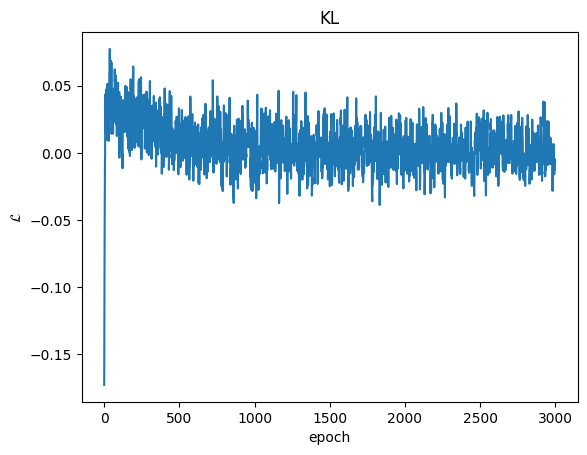

In [19]:
# Loss function
plt.plot(np.arange(len(history['loss'])),history['loss'])
plt.title('KL')
plt.xlabel('epoch')
plt.ylabel(r'$\mathcal{L}$')
# plt.savefig(plot_dir+model_name+'_lc.jpg')
plt.show()

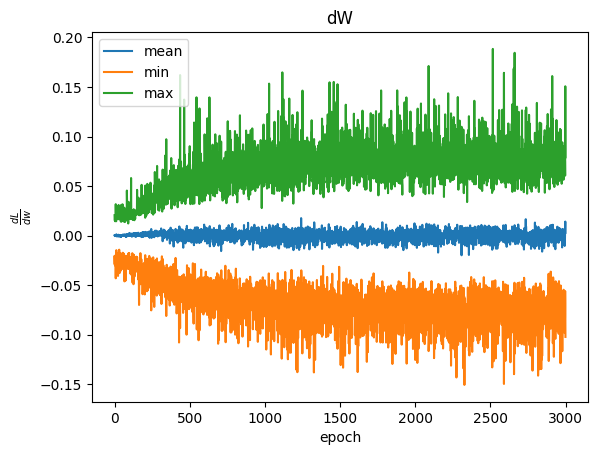

In [20]:
# Gradient
plt.plot(np.arange(len(history['dw'])),np.mean(np.mean(history['dw'], axis=1),axis=1), label='mean')
plt.plot(np.arange(len(history['dw'])),np.min(np.min(history['dw'], axis=1),axis=1), label='min')
plt.plot(np.arange(len(history['dw'])),np.max(np.max(history['dw'], axis=1),axis=1), label='max')
plt.title('dW')
plt.xlabel('epoch')
plt.ylabel(r'$\frac{d L}{dw}$')
plt.legend()
# plt.savefig(plot_dir+model_name+'_lc.jpg')
plt.show()

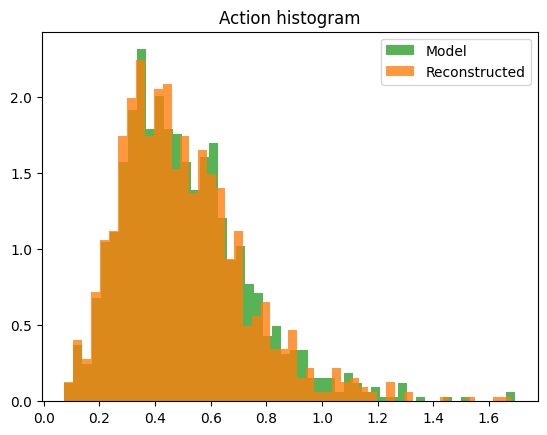

In [22]:
n_samples = 1000
recon_field = torch.ones((n_samples, N))
v_pred, v_, h_pred, _, v = rbm.forward(recon_field,n_samples)
n_samples = len(v)
# S_true = np.zeros(n_data)
S_pred = np.zeros(n_samples)
S_K = np.zeros(n_samples)
M = m*np.ones(N)

# for i in range(n_data):
#     S_true[i] = S(data_file[i],M)

for i in range(n_samples):
    S_pred[i] = S(v_.data.numpy()[i],M)
    S_K[i] = -rbm.free_energy(v_[i:i+1]).data.numpy()
#     w_ = rbm.W.data.numpy().copy()
#     m_ = rbm.mass.data.numpy().copy()
#     sig_ = rbm.h_std
#     Kin = -sig_**2 *(w_.T @ w_)
#     Mss = np.diag(m_**2)m
#     s_ = 0.5 * v_pred.data.numpy()[i] @ (Kin + Mss) @ v_pred.data.numpy()[i].T/N
#     S_K[i] = s_

plt.hist(S_K, bins=50, density=True, color='C2', label='Model', alpha=0.8)
plt.hist(S_pred, bins=50, density=True, color='C1', label='Reconstructed', alpha=0.8)    
# plt.hist(S_true, bins=50, density=True, color='C0', label='MCMC data', alpha=0.8)
plt.legend()
plt.title('Action histogram')
# plt.savefig(plot_dir+model_name+'_S.jpg')
plt.show()

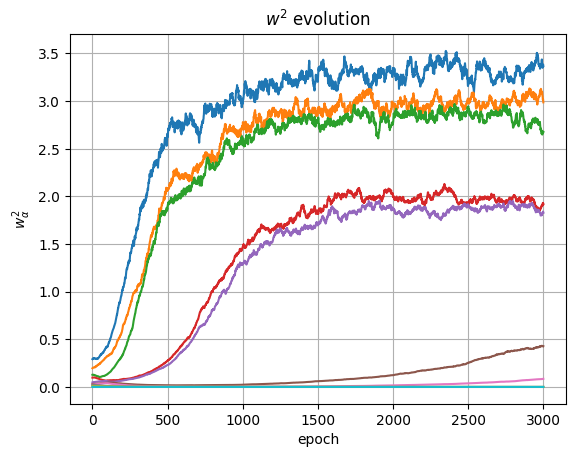

In [23]:
# SVD of coupling matrix squared
s_hist = np.zeros((epochs,N))
for i in range(epochs):
    _, s_, _ = np.linalg.svd(history['w'][i])
    s_hist[i] = s_

plt.plot(np.arange(epochs),s_hist**2)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}^2$')
plt.title(r'$w^2$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

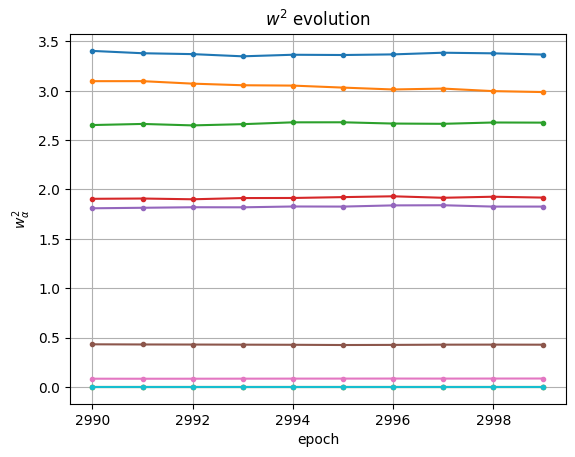

In [24]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:]**2, '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}^2$')
plt.title(r'$w^2$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

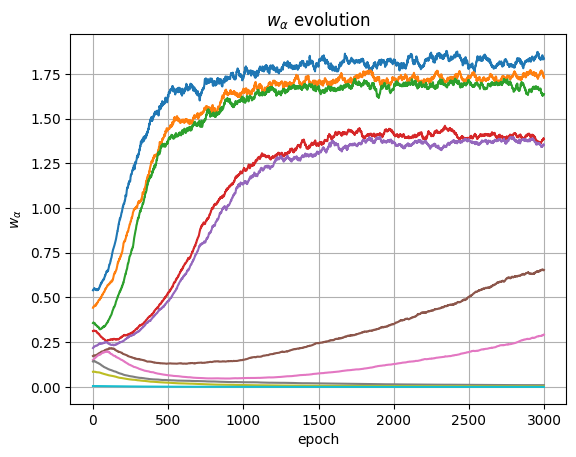

In [25]:
# SVD of coupling matrix not squared
plt.plot(np.arange(epochs),s_hist, '-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}$')
plt.title(r'$w_{\alpha}$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

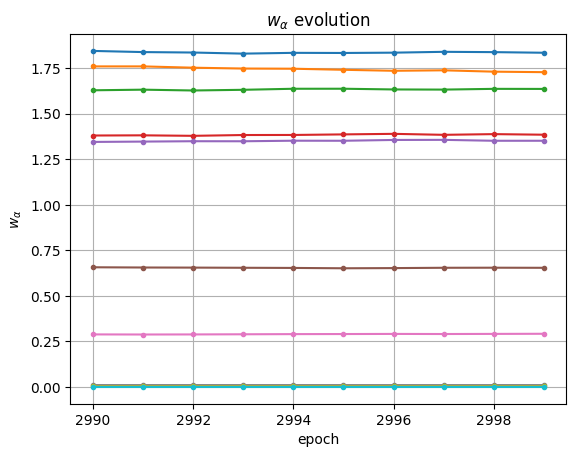

In [26]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:], '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$w_{\alpha}$')
plt.title(r'$w_{\alpha}$ evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

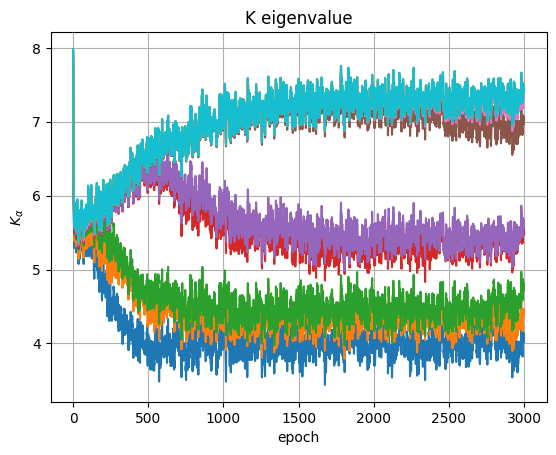

In [27]:
# Kernel SVD values
s_hist = np.zeros((epochs,N))
mu2 = np.diag(np.ones(N))

for i in range(epochs):
    WW_ = history['w'][i].T@history['w'][i]
    K_ = -rbm.sig**2 * WW_ + np.diag(history['m'][i]**2)
    if i ==0:
        K_i = K_.copy()
    s_ = np.sort(np.linalg.eigvals(K_))
    s_hist[i] = s_

plt.plot(np.arange(epochs),s_hist)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$K_{\alpha}$')
plt.title('K eigenvalue')
# plt.savefig(plot_dir+model_name+'_K.jpg')
plt.show()

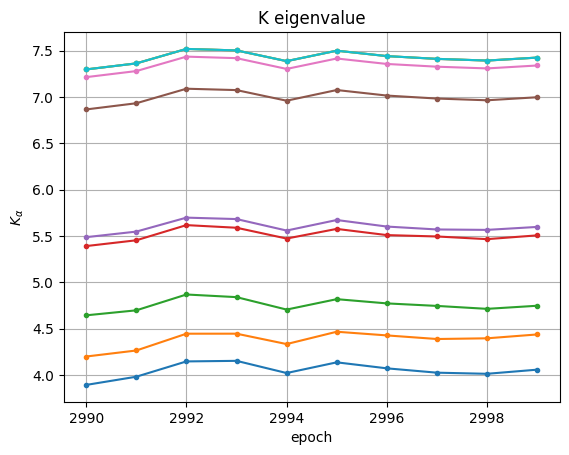

In [28]:
# Last few steps
plt.plot(np.arange(epochs)[-10:],s_hist[-10:], '.-')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$K_{\alpha}$')
plt.title('K eigenvalue')
# plt.savefig(plot_dir+model_name+'_K.jpg')
plt.show()

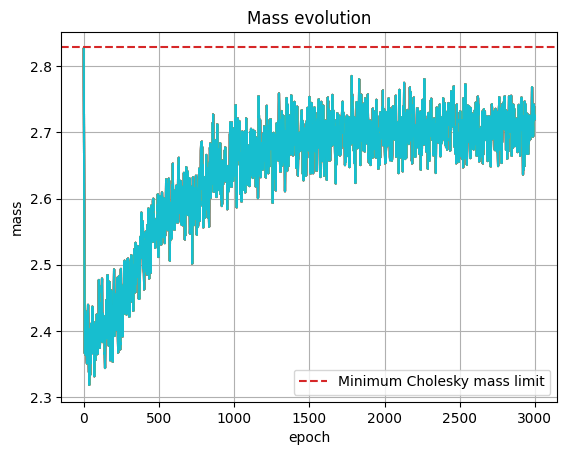

In [29]:
# Mass parameter of the model
plt.plot(np.arange(len(history['m'])),history['m'])
plt.axhline(np.sqrt(m**2 + 2. + 2.), ls='--', color='C3', label='Minimum Cholesky mass limit')
plt.title('Mass evolution')
plt.xlabel('epoch')
plt.ylabel('mass')
plt.legend()
plt.grid(True)
# plt.savefig(plot_dir+model_name+'_mass.jpg')
plt.show()

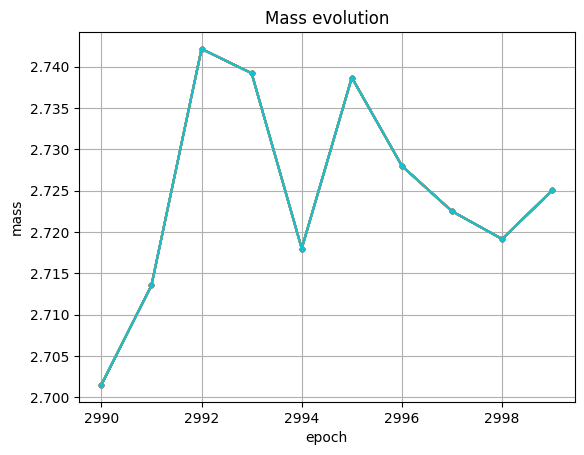

In [30]:
# Last few steps
plt.plot(np.arange(len(history['m']))[-10:],history['m'][-10:], '.-')
# plt.axhline(np.sqrt(m**2 + 2. + 2.), ls='--', color='C3', label='Minimum Cholesky mass limit')
plt.title('Mass evolution')
plt.xlabel('epoch')
plt.ylabel('mass')
# plt.legend()
plt.grid(True)
# plt.savefig(plot_dir+model_name+'_mass.jpg')
plt.show()

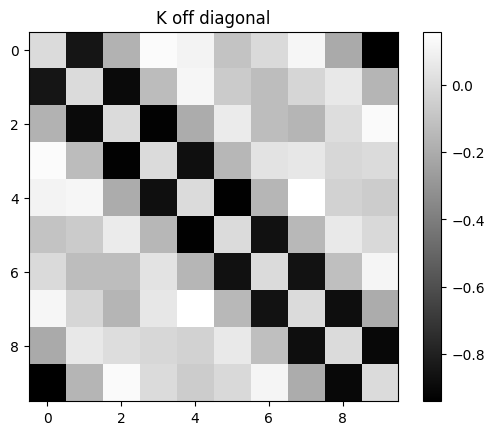

In [31]:
# K_rbm off diagonal part
Kin = (-rbm.sig**2 * (rbm.w.t() @ rbm.w)).data.numpy()
Mss = np.diag((rbm.m**2).data.numpy())
K = Kin + Mss

K_off = K - np.diag(np.diag(K))
plt.imshow(K_off, cmap='gray', vmax=K_off.max(), vmin=K_off.min())
plt.colorbar()
plt.title('K off diagonal')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

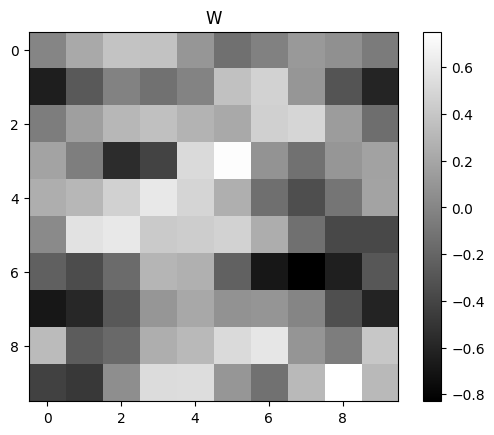

In [32]:
# Coupling matrix as image
w_rbm = rbm.w.data.numpy()
plt.imshow(w_rbm, cmap='gray')
plt.colorbar()
plt.title('W')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

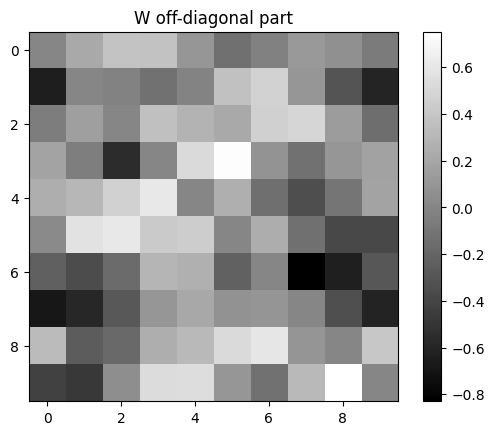

In [33]:
# Coupling matrix off-diagonal
w_rbm = rbm.w.data.numpy()
plt.imshow(w_rbm - np.diag(np.diag(w_rbm)), cmap='gray')
plt.colorbar()
plt.title('W off-diagonal part')
# plt.savefig(plot_dir+model_name+'_K_img.jpg')
plt.show()

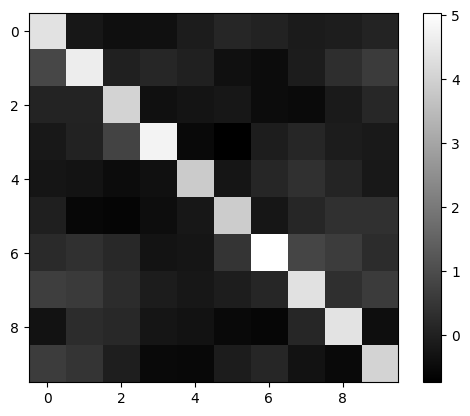

mean:  0.40421854086935527
std:  1.362264702544486


In [34]:
# Difference between Choleski(initial) solution to the trained solution
diff = W_phi - w_rbm
plt.imshow(diff, cmap='gray')
plt.colorbar()
plt.show()

print('mean: ',np.mean(diff))
print('std: ',np.std(diff))

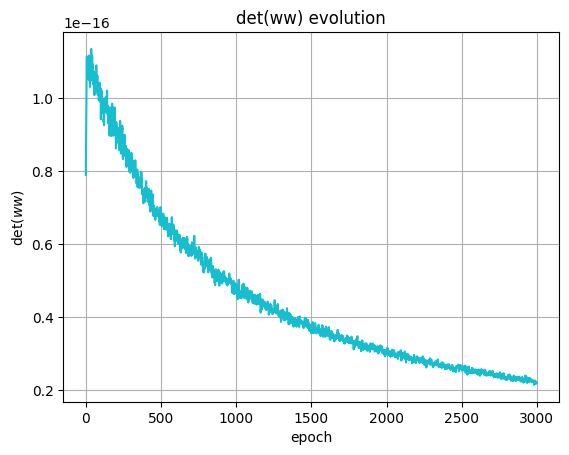

In [35]:
# Evolution of det(ww^T)
det_hist = np.zeros(epochs)
for i in range(epochs):
    det = np.linalg.det(history['w'][i].T @ history['w'][i])
    det_hist[i] = det

plt.plot(np.arange(epochs),det_hist,'C9')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'det($ww$)')
plt.title(r'det(ww) evolution')
# plt.savefig(plot_dir+model_name+'_w.jpg')
plt.show()

# Scaling of K_RBM

In [36]:
# Least square fit
def loss(K, K_phi, Zk, b, r):
    return np.sum((K - Zk*K_phi - b - r)**2)

def dL_dZ(K, K_phi, Zk, b, r):
    return -np.sum(2.*(K - Zk*K_phi - b - r)*K_phi)

def dL_db(K, K_phi, Zk, b, r):
    return -np.sum(2.*(K - Zk*K_phi - b - r))

def dL_dr(K, K_phi, Zk, b, r):
    return -2.*(K - Zk*K_phi - b - r)

def get_scale(model, verbose=True):
    Kin = (-model.sig**2 * (model.w.t() @ model.w)).data.numpy()
    Mss = np.diag((model.m**2).data.numpy())
    K = Kin + Mss
    mu_ = model.m.data.numpy()
    Zk_gd = mu_.min()**2/(2.**2 + 4)

    np.random.seed(1234)
    r_seed = np.random.normal(0.,.01,size=K.shape) # ~ sigma^2
    r_gd = r_seed.T @ r_seed
    b_gd = 0.
    lr = 1e-5

    for i in range(10000):
        l = loss(K, K_phi, Zk_gd, b_gd, r_gd)
    #     print(l)
        dZ = lr * dL_dZ(K, K_phi, Zk_gd, b_gd, r_gd)
        db = lr * dL_db(K, K_phi, Zk_gd, b_gd, r_gd)
        dr = lr * dL_dr(K, K_phi, Zk_gd, b_gd, r_gd)

        Zk_gd -= dZ
        b_gd -= db
        r_gd -= dr
        if i%1000 == 0 and verbose:
            print(i, l, Zk_gd, b_gd)
            
    return Zk_gd, b_gd, r_gd, K

In [37]:
Zk, b, r, K = get_scale(rbm)

0 3.830917612868069 0.928846224080255 7.058423940334555e-05
1000 1.269339704089038 1.0087591632807347 0.0041732589124063
2000 1.219431867120619 1.0089369928711323 0.0031481122882268515
3000 1.171613820881505 1.0089583703930103 0.00299557968651782
4000 1.125673670434315 1.0089615345745406 0.0029729873008295976
5000 1.0815349404358876 1.0089620032306579 0.002969641070425679
6000 1.0391269331572817 1.0089620726448092 0.0029691454495711523
7000 0.998381783957452 1.0089620829259596 0.00296907204158622
8000 0.9592342905694525 1.0089620844487348 0.0029690611688954404
9000 0.9216218073981884 1.0089620846742773 0.002969059558506401


In [38]:
Zk

1.008962084707672

# Compare Kernel

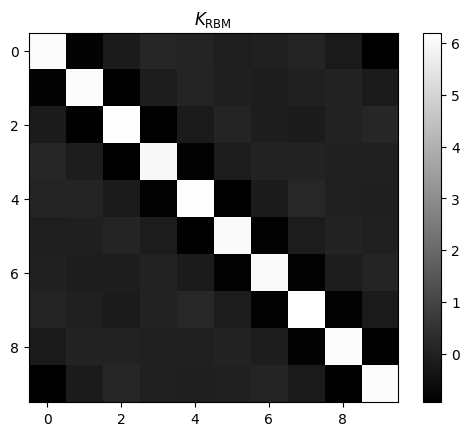

In [39]:
# Trained Kernel
plt.title(r"$K_{\rm RBM}$")
plt.imshow(K, cmap='gray')
plt.colorbar()
plt.show()

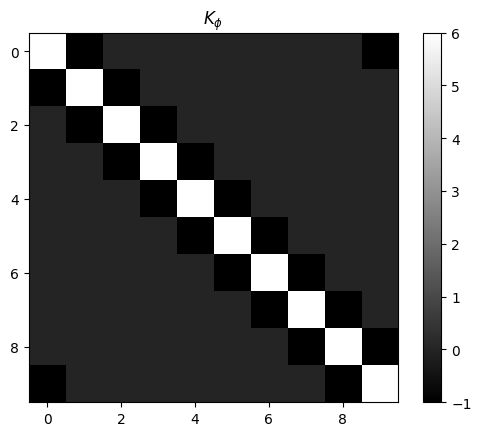

In [40]:
# Trained Kernel
plt.title(r"$K_{\phi}$")
plt.imshow(K_phi, cmap='gray')
plt.colorbar()
plt.show()

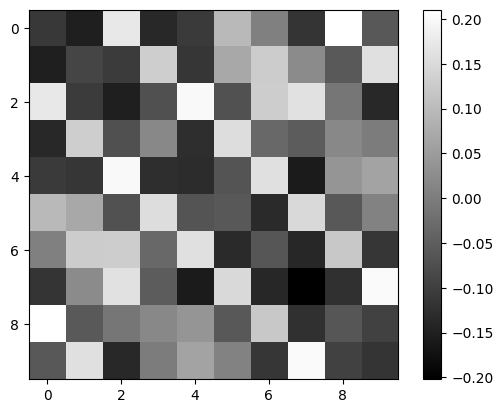

mean:  -0.006638948891827472
std:  0.11629260780737032


In [41]:
# Difference between Choleski(initial) solution to the trained solution
diff = K_phi - K
plt.imshow(diff, cmap='gray')
plt.colorbar()
plt.show()

print('mean: ',np.mean(diff))
print('std: ',np.std(diff))

# Compare two-point correlator

In [42]:
n_samples = 1000
init_field = torch.ones((n_samples,N))
regen, regen_, _, _, in_data = rbm.forward(init_field,10)

In [43]:
C_phi = np.linalg.inv(K_phi)
C_rbm_kernel = np.linalg.inv(K)
C_rbm_sample = np.cov(regen_.data.numpy().copy().T)

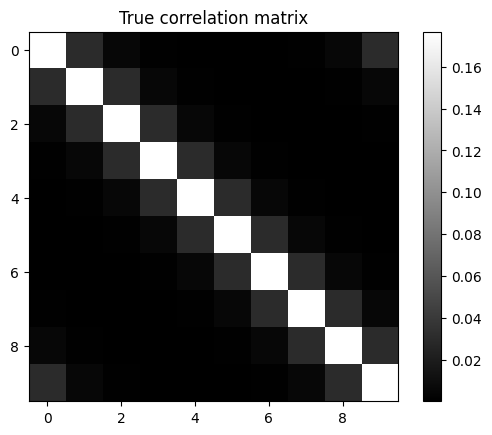

In [44]:
plt.title('True correlation matrix')
plt.imshow(C_phi, cmap='gray')
plt.colorbar()
plt.show()

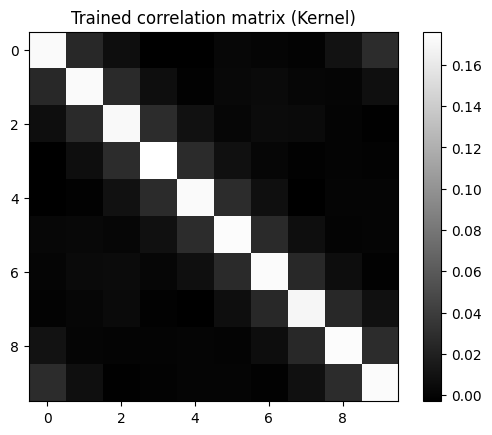

In [45]:
plt.title('Trained correlation matrix (Kernel)')
plt.imshow(C_rbm_kernel, cmap='gray')
plt.colorbar()
plt.show()

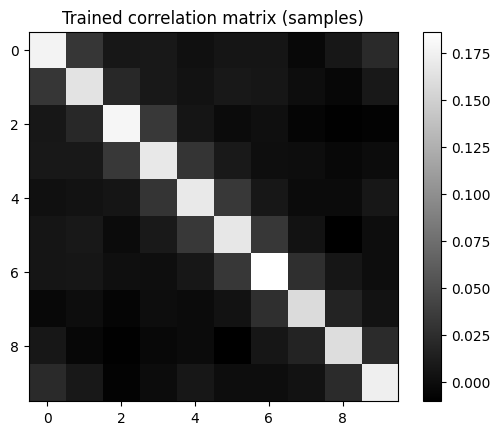

In [46]:
plt.title('Trained correlation matrix (samples)')
plt.imshow(C_rbm_sample, cmap='gray')
plt.colorbar()
plt.show()